## Imports

In [1]:
!pip install PyWavelets

import re
import contextlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pywt
from scipy import signal, stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, MaxPooling1D, Dropout

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import butter, filtfilt, detrend
import numpy as np
from sklearn.preprocessing import RobustScaler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.8 MB/s eta 0:00:00


## Data Cleaning and Preprocessing

In [2]:
def load_io_dataset(base_path: str) -> pd.DataFrame:
    """Load all IO dataset files with proper structure"""
    base_path = Path(base_path)
    data_files = list(base_path.glob("EEG-IO/S*_data.csv"))

    if not data_files:
        raise FileNotFoundError(f"No IO data files found in {base_path/'EEG-IO'}")

    all_data = []

    for data_file in data_files:
        # Load EEG data with correct column mapping
        df = pd.read_csv(
            data_file,
            sep=';',  # Files use semicolon separators
            header=0,  # First line contains headers
            usecols=['Time (s)', 'FP1', 'FP2'],  # Select relevant columns
            dtype={'Time (s)': 'float32', 'FP1': 'float32', 'FP2': 'float32'}
        )

        # Convert time to sample index (250Hz sampling rate)
        df['SampleIndex'] = (df['Time (s)'] * 250).astype('int32')
        df = df[['SampleIndex', 'FP1', 'FP2']]

        # Load corresponding labels
        label_file = data_file.parent / data_file.name.replace('_data.csv', '_labels.csv')
        labels = load_io_labels(label_file)

        # Merge labels with EEG data
        df = pd.merge(df, labels, on='SampleIndex', how='left')
        df['Blink'] = df['Blink'].fillna(0).astype('int8')

        all_data.append(df)

    return pd.concat(all_data).reset_index(drop=True)

def load_io_labels(label_file: Path) -> pd.DataFrame:
    """Parse IO label files with corrupt intervals and blink markers"""
    if not label_file.exists():
        raise FileNotFoundError(f"Label file missing: {label_file}")

    with open(label_file) as f:
        lines = [line.strip() for line in f if line.strip()]

    # Parse corrupt intervals (we'll just log these for now)
    corrupt = []
    if lines[0].startswith('corrupt'):
        n_corrupt = int(lines[0].split(',')[-1])
        corrupt = [tuple(map(float, line.split(',')))
                 for line in lines[1:1+n_corrupt]]

    # Parse blinks (our main focus)
    blinks = []
    blink_start = lines.index('blinks') + 1
    for line in lines[blink_start:]:
        time, code = line.split(',')
        blinks.append({
            'SampleIndex': int(float(time) * 250),  # Convert to samples
            'Blink': 1,
            'TrialType': int(code)  # 1 indicates involuntary blink in IO dataset
        })

    return pd.DataFrame(blinks)

In [3]:
try:
    io_data = load_io_dataset("EEG-EyeBlinks/")
    print(io_data[['SampleIndex', 'FP1', 'FP2', 'Blink']].head())
except Exception as e:
    print(f"Error loading data: {str(e)}")

   SampleIndex           FP1          FP2  Blink
0            0  16046.741211  7003.359863      0
1            0  16090.081055  7036.462891      0
2            1  16099.849609  7041.559082      0
3            2  16047.590820  7025.913086      0
4            3  16027.429688  7030.651367      0


In [4]:
def clean_io_data(raw_df: pd.DataFrame,
                 lowcut: float = 1.0,
                 highcut: float = 30.0,
                 fs: float = 250.0) -> pd.DataFrame:
    """
    Clean and preprocess IO dataset with:
    - Bandpass filtering
    - Blink artifact handling
    - Normalization
    - Outlier removal
    """
    df = raw_df.copy()

    # Filtering
    print("Applying bandpass filter...")
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    # Butterworth bandpass filter
    b, a = butter(4, [low, high], btype='band')
    for col in ['FP1', 'FP2']:
        df[col] = filtfilt(b, a, df[col])

    # Remove linear trends
    print("Detrending signals...")
    for col in ['FP1', 'FP2']:
        df[col] = detrend(df[col], type='linear')

    # Normalize using robust scaling
    print("Normalizing signals...")
    scaler = RobustScaler()
    df[['FP1', 'FP2']] = scaler.fit_transform(df[['FP1', 'FP2']])

    # Handle outliers using IQR
    print("Removing outliers...")
    for col in ['FP1', 'FP2']:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        df[col] = np.clip(df[col], q1 - 1.5*iqr, q3 + 1.5*iqr)

    # Create blink-centered epochs
    print("Creating blink epochs...")
    blink_epochs = []
    blink_indices = df[df['Blink'] == 1].index
    epoch_id = 0

    for idx in blink_indices:
        epoch_start = max(0, idx - 25)  # 100ms pre-blink
        epoch_end = min(len(df), idx + 100)  # 400ms post-blink
        epoch = df.iloc[epoch_start:epoch_end].copy()

        # Add epoch metadata
        epoch['EpochID'] = epoch_id
        relative_peak = idx - epoch_start
        epoch['BlinkPeak'] = 0
        epoch.iloc[relative_peak, epoch.columns.get_loc('BlinkPeak')] = 1

        blink_epochs.append(epoch)
        epoch_id += 1

    return pd.concat(blink_epochs).reset_index(drop=True)

In [5]:
def plot_cleaning_comparison(raw_df, cleaned_df):
    plt.figure(figsize=(12, 6))

    # Raw data plot
    plt.subplot(2, 1, 1)
    plt.plot(raw_df['FP1'].values[:500], label='FP1 Raw')
    plt.plot(raw_df['FP2'].values[:500], label='FP2 Raw')
    plt.title("Raw EEG Signals")
    plt.ylabel("Amplitude (μV)")
    plt.legend()

    # Cleaned data plot
    plt.subplot(2, 1, 2)
    plt.plot(cleaned_df['FP1'].values[:500], label='FP1 Cleaned')
    plt.plot(cleaned_df['FP2'].values[:500], label='FP2 Cleaned')
    plt.title("Cleaned EEG Signals")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Units")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
def analyze_blink_epochs(cleaned_df):
    """Updated analysis with proper dataframe creation"""
    aligned_epochs = []

    # Group by EpochID
    for epoch_id, epoch in cleaned_df.groupby('EpochID'):
        try:
            peak_idx = epoch[epoch['BlinkPeak'] == 1].index[0]
        except IndexError:
            continue  # Skip epochs without peaks

        # Convert to relative time
        epoch['TimeFromPeak'] = (epoch.index - peak_idx) / 250
        aligned_epochs.append(epoch)

    # Create combined dataframe
    aligned_df = pd.concat(aligned_epochs)

    # Plot average blink response
    plt.figure(figsize=(10, 4))
    for channel in ['FP1', 'FP2']:
        avg_response = aligned_df.groupby('TimeFromPeak')[channel].mean()
        plt.plot(avg_response.index, avg_response, label=channel)

    plt.axvline(0, color='red', linestyle='--', label='Blink Peak')
    plt.title("Average Blink Response")
    plt.xlabel("Time from Blink Peak (s)")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

Applying bandpass filter...
Detrending signals...
Normalizing signals...
Removing outliers...
Creating blink epochs...


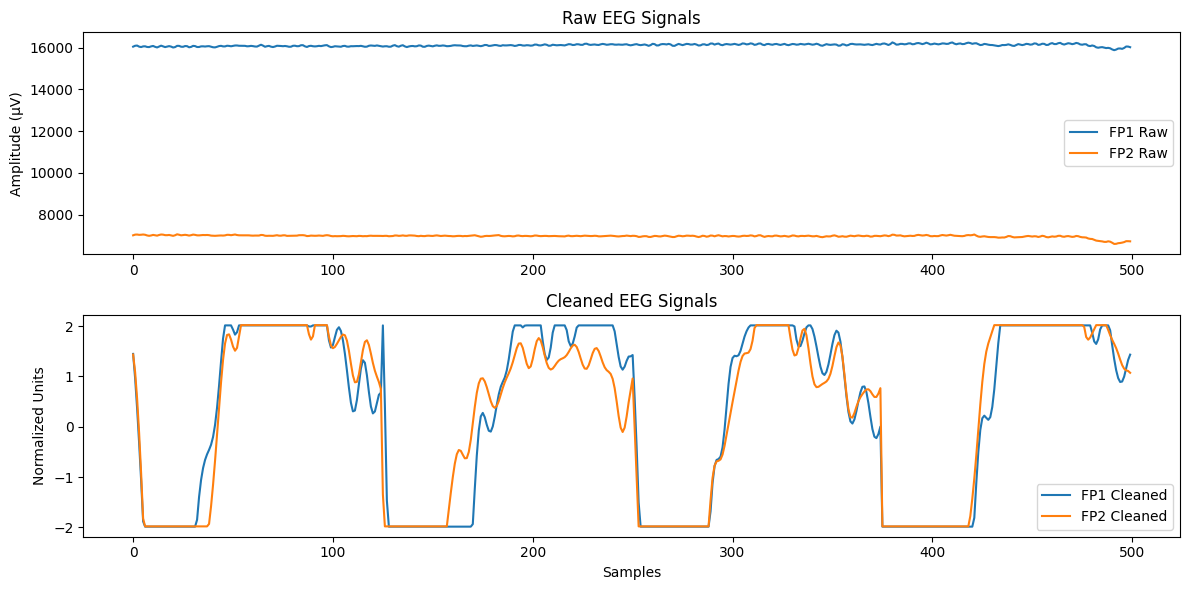

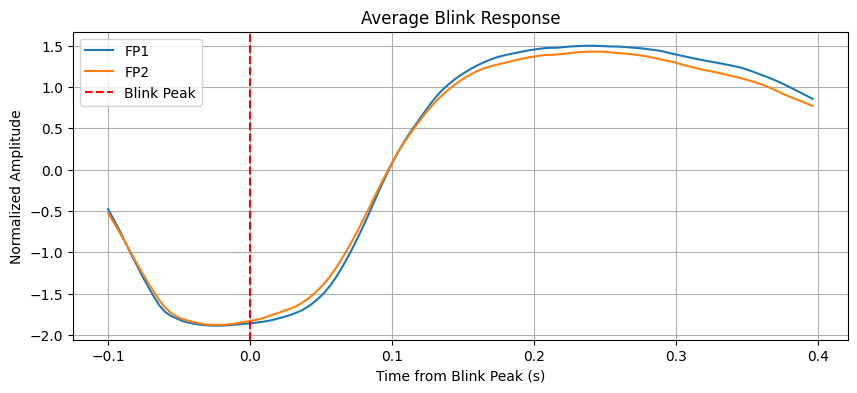

In [7]:
# Load and clean
io_raw = load_io_dataset("EEG-EyeBlinks/")
io_clean = clean_io_data(io_raw)

# Analyze
plot_cleaning_comparison(io_raw, io_clean)
analyze_blink_epochs(io_clean)

# Save cleaned data
io_clean.to_feather("cleaned_io_data.feather")

In [8]:
def load_vr_vv_data(base_path: str, dataset_type: str) -> pd.DataFrame:
    """Final fixed version with complete error handling"""
    base_path = Path(base_path)
    folder = "EEG-VR" if dataset_type == "VR" else "EEG-VV"
    data_files = list(base_path.glob(f"{folder}/S*{'R' if dataset_type == 'VR' else 'V'}_data.csv"))

    if not data_files:
        raise FileNotFoundError(f"No {dataset_type} data files found in {base_path/folder}")

    all_data = []

    for data_file in data_files:
        # Load EEG data with validation
        try:
            # Read data WITHOUT using the file's sample index
            df = pd.read_csv(
                data_file,
                comment='%',
                header=None,
                skiprows=4,
                usecols=[1, 2],  # Skip first column
                names=['FP1', 'FP2'],  # Remove SampleIndex from names
                dtype={'FP1': 'float32', 'FP2': 'float32'}
            )
            # Add proper sequential index
            df['SampleIndex'] = df.index.astype('int32')  # New line
        except Exception as e:
            print(f"Error loading {data_file}: {e}")
            continue

        # Load corresponding labels
        label_file = data_file.parent / f"{data_file.stem.replace('_data', '_labels')}.csv"
        if not label_file.exists():
            print(f"Missing label file: {label_file}")
            continue

        try:
            labels = parse_vr_vv_labels(label_file, dataset_type)
        except Exception as e:
            print(f"Error parsing {label_file}: {e}")
            continue

        # Validate label indices against data
        if not labels.empty:
            max_sample = df['SampleIndex'].max()
            label_samples = labels['SampleIndex']
            valid_labels = labels[label_samples <= max_sample]

            if len(valid_labels) < len(labels):
                print(f"Warning: {len(labels)-len(valid_labels)} label(s) exceed data length in {data_file}")
        else:
            valid_labels = labels

        # Merge and validate
        if not valid_labels.empty:
            df = pd.merge(df, valid_labels, on='SampleIndex', how='left')
        else:
            df['Blink'] = 0
            df['TrialType'] = -1

        # Final cleanup
        df['Blink'] = df['Blink'].fillna(0).astype('int8')
        df['TrialType'] = df['TrialType'].fillna(-1).astype('int8')
        df['DatasetType'] = dataset_type
        all_data.append(df)

    if not all_data:
        raise ValueError(f"No valid data loaded for {dataset_type} dataset")

    return pd.concat(all_data).reset_index(drop=True)

def parse_vr_vv_labels(label_file: Path, dataset_type: str) -> pd.DataFrame:
    """Final fixed label parser with time validation"""
    blinks = []
    try:
        with open(label_file, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]

        if 'blinks' not in lines:
            print(f"No blink section in {label_file}")
            return pd.DataFrame()

        blink_start = lines.index('blinks') + 1
        for line_num, line in enumerate(lines[blink_start:], blink_start+1):
            if not line or ',' not in line:
                continue

            try:
                time_str, code = line.split(',', 1)
                time_sec = float(time_str)
                sample_idx = int(round(time_sec * 250))  # Proper rounding

                # Validate code before adding
                trial_type = 0 if (dataset_type == 'VR' and int(code) == 0) else 1
                blinks.append({
                    'SampleIndex': sample_idx,
                    'Blink': 1,
                    'TrialType': trial_type
                })

            except ValueError as e:
                print(f"Invalid line {line_num} '{line}' in {label_file}: {e}")

    except Exception as e:
        print(f"Error reading {label_file}: {e}")

    return pd.DataFrame(blinks).astype({
        'SampleIndex': 'int32',
        'Blink': 'int8',
        'TrialType': 'int8'
    })

In [9]:
def clean_vr_vv_data(raw_df: pd.DataFrame,
                    lowcut: float = 0.5,  # Wider band for voluntary blinks
                    highcut: float = 40.0,
                    fs: float = 250.0) -> pd.DataFrame:
    """
    Process VR/VV datasets with:
    - Extended bandpass filtering
    - Voluntary blink handling
    - Trial-type aware processing
    """
    df = raw_df.copy()

    # Filtering with wider band
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut/nyq, highcut/nyq], btype='band')
    for col in ['FP1', 'FP2']:
        df[col] = filtfilt(b, a, df[col])

    # Remove nonlinear trends
    for col in ['FP1', 'FP2']:
        df[col] = detrend(df[col], type='linear')

    # Trial-type specific normalization
    print("Normalizing signals...")
    scaler = RobustScaler()
    for trial_type in df['TrialType'].unique():
        mask = df['TrialType'] == trial_type
        if mask.sum() > 0:  # Only process if samples exist
            df.loc[mask, ['FP1', 'FP2']] = scaler.fit_transform(df.loc[mask, ['FP1', 'FP2']])
        else:
            print(f"Warning: No samples found for trial type {trial_type}")

    # Outlier handling with trial-type consideration
    print("Handling outliers...")
    for col in ['FP1', 'FP2']:
        for trial_type in df['TrialType'].unique():
            mask = df['TrialType'] == trial_type
            if mask.sum() > 0:  # Only process if samples exist
                subset = df.loc[mask, col]
                q1 = subset.quantile(0.25)
                q3 = subset.quantile(0.75)
                iqr = q3 - q1
                df.loc[mask, col] = np.clip(subset, q1 - 1.5*iqr, q3 + 1.5*iqr)

    # Create voluntary blink epochs (fixed)
    print("Creating blink epochs...")
    blink_epochs = []
    blink_indices = df[df['Blink'] == 1].index
    epoch_id = 0  # Initialize counter

    if len(blink_indices) == 0:
        raise ValueError("No blink markers found - check label files and data loading")

    for idx in blink_indices:
        # Larger window for voluntary blinks
        epoch_start = max(0, idx - 50)  # 200ms pre-blink
        epoch_end = min(len(df), idx + 150)  # 600ms post-blink
        epoch = df.iloc[epoch_start:epoch_end].copy()

        # Add metadata
        epoch['EpochID'] = epoch_id
        epoch['TrialType'] = df.at[idx, 'TrialType']  # Preserve trial type
        relative_peak = idx - epoch_start
        epoch['BlinkPeak'] = 0
        epoch.iloc[relative_peak, epoch.columns.get_loc('BlinkPeak')] = 1

        blink_epochs.append(epoch)
        epoch_id += 1  # Increment counter

    if not blink_epochs:
        print("Warning: No valid blink epochs created")
        return pd.DataFrame()

    return pd.concat(blink_epochs).reset_index(drop=True)

def plot_vr_vv_comparison(vr_df, vv_df):
    """Compare VR recalibration vs VV voluntary blinks"""
    plt.figure(figsize=(12, 6))

    # VR plot
    plt.subplot(2, 1, 1)
    for trial_type in vr_df['TrialType'].unique():
        subset = vr_df[vr_df['TrialType'] == trial_type]
        label = 'Involuntary' if trial_type == 0 else 'Voluntary'
        plt.plot(subset['FP1'].values[:500], label=f'VR {label}')
    plt.title("VR Recalibration Blinks")
    plt.ylabel("Normalized Units")
    plt.legend()

    # VV plot
    plt.subplot(2, 1, 2)
    subset = vv_df[vv_df['TrialType'] == 1]  # VV only has voluntary
    plt.plot(subset['FP1'].values[:500], label='VV Voluntary')
    plt.title("Voluntary Blinks")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Units")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
# Check VR labels
vr_raw = load_vr_vv_data("EEG-EyeBlinks", "VR")
print(f"VR blinks: {vr_raw['Blink'].sum()}")

# Check VV labels
vv_raw = load_vr_vv_data("EEG-EyeBlinks", "VV")
print(f"VV blinks: {vv_raw['Blink'].sum()}")

def debug_parse_labels(file_path: str, dataset_type: str):
    """Debug helper for label files"""
    labels = parse_vr_vv_labels(Path(file_path), dataset_type)
    print(f"Labels from {file_path}:")
    print(labels[labels['Blink'] == 1].head(10))

# Example usage:
debug_parse_labels("EEG-EyeBlinks/EEG-VR/S00R_labels.csv", "VR")

def check_data_alignment(df):
    """Verify EEG samples have corresponding labels"""
    print("Data alignment check:")
    print(f"Total samples: {len(df)}")
    print(f"Blink markers: {df['Blink'].sum()}")
    print(f"Missing TrialType: {df['TrialType'].isna().sum()}")

check_data_alignment(vr_raw)
check_data_alignment(vv_raw)

VR blinks: 678
VV blinks: 799
Labels from EEG-EyeBlinks/EEG-VR/S00R_labels.csv:
   SampleIndex  Blink  TrialType
0          995      1          0
1         2675      1          0
2         4518      1          0
3         5650      1          0
4         6445      1          0
5         8052      1          0
6         8288      1          0
7        10780      1          1
8        10890      1          0
9        11962      1          0
Data alignment check:
Total samples: 1157647
Blink markers: 678
Missing TrialType: 0
Data alignment check:
Total samples: 1076365
Blink markers: 799
Missing TrialType: 0


In [11]:
# Output number of Involuntary Blinks
print((io_clean['Blink'] == 1).sum())

561


Normalizing signals...
Handling outliers...
Creating blink epochs...
Normalizing signals...
Handling outliers...
Creating blink epochs...


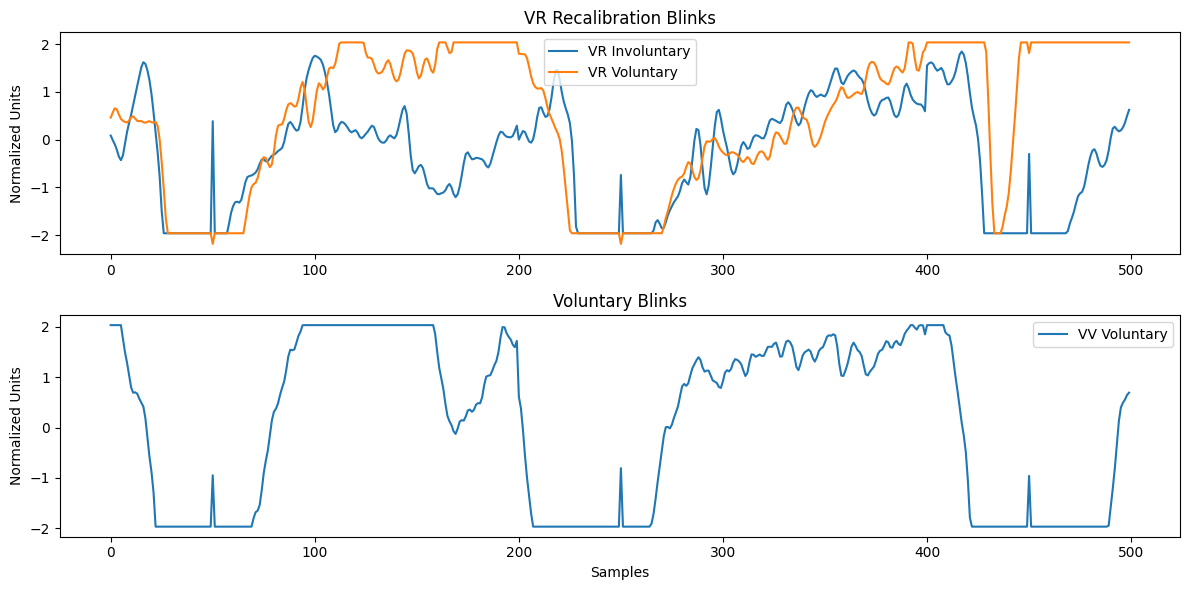

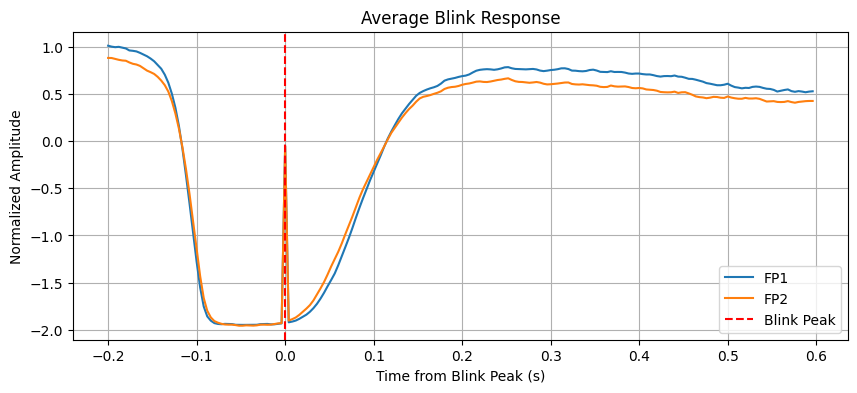

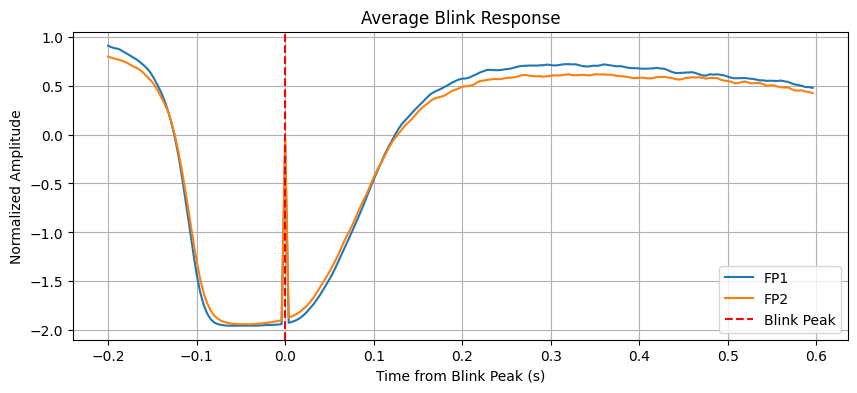

In [12]:
# Clean data
vr_clean = clean_vr_vv_data(vr_raw)
vv_clean = clean_vr_vv_data(vv_raw)

# Analyze
plot_vr_vv_comparison(vr_clean, vv_clean)
analyze_blink_epochs(vr_clean)  # Reuse same analysis function
analyze_blink_epochs(vv_clean)

# Save separately
vr_clean.to_feather("cleaned_vr_data.feather")
vv_clean.to_feather("cleaned_vv_data.feather")

In [13]:
# EEG-IO (Voluntary Blinks)
# EEG-VV & EEG-VR (Involuntary Blinks)

combined_data = pd.concat(
    [
        vv_clean.assign(VoluntaryBlink=0),
        vr_clean.assign(VoluntaryBlink=0),
        io_clean.assign(VoluntaryBlink=1)
    ],
    ignore_index=True
)

## 1-D CNN Model - Voluntary/Involuntary Blinks Classification

In [ ]:
def create_sliding_windows(
    df,
    window_size=250,
    stride=50,
    channels=["FP1", "FP2"],
    label_col="VoluntaryBlink"
):

    eeg_data = df[channels].values  # shape: (n_samples, n_channels)
    labels = df[label_col].values   # shape: (n_samples,)

    n_samples = len(df)

    X_list = []
    y_list = []

    # Slide from start=0 to the last valid window start
    # so that we always have a full window of 'window_size'
    for start_idx in range(0, n_samples - window_size + 1, stride):
        end_idx = start_idx + window_size
        # Window data
        window_eeg = eeg_data[start_idx:end_idx]    # shape: (window_size, n_channels)
        window_lbl = labels[start_idx:end_idx]      # shape: (window_size,)

        # Label = 1 if there's any "1" in this window
        y_val = 1 if np.sum(window_lbl) > 0 else 0

        X_list.append(window_eeg)
        y_list.append(y_val)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y

#  window_size of 250 (1 second @ 250 Hz)
window_size = 250
stride = 50

X, y = create_sliding_windows(
    df=combined_data,
    window_size=window_size,
    stride=stride,
    channels=["FP1", "FP2"],
    label_col="VoluntaryBlink"
)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize Using Training Data Stats
train_mean = np.mean(X_train, axis=(0,1))
train_std = np.std(X_train, axis=(0,1))

X_train = (X_train - train_mean) / (train_std + 1e-8)
X_test  = (X_test  - train_mean) / (train_std + 1e-8)


num_classes = 2
y_train_oh = to_categorical(y_train, num_classes)
y_test_oh  = to_categorical(y_test, num_classes)

# 1D CNN Model

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X.shape[-1])),
    MaxPooling1D(pool_size=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # 2-class classification
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Trainning
history = model.fit(
    X_train, y_train_oh,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


# Evaluating
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


X shape: (7299, 250, 2)
y shape: (7299,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 248, 64)             │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 124, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 124, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │         253,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,498 (994.13 KB)

 Trainable params: 254,498 (994.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8452 - loss: 0.3379 - val_accuracy: 0.9675 - val_loss: 0.0895
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9766 - loss: 0.0652 - val_accuracy: 0.9726 - val_loss: 0.0735
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9908 - loss: 0.0321 - val_accuracy: 0.9812 - val_loss: 0.0540
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9875 - loss: 0.0306 - val_accuracy: 0.9795 - val_loss: 0.0645
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9947 - loss: 0.0175 - val_accuracy: 0.9846 - val_loss: 0.0793
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9920 - loss: 0.0219 - val_accuracy: 0.9829 - val_loss: 0.0473
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9947 - loss: 0.0137 - val_accuracy: 0.9863 - val_loss: 0.0504
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9967 - loss: 0.0092 - val_accu

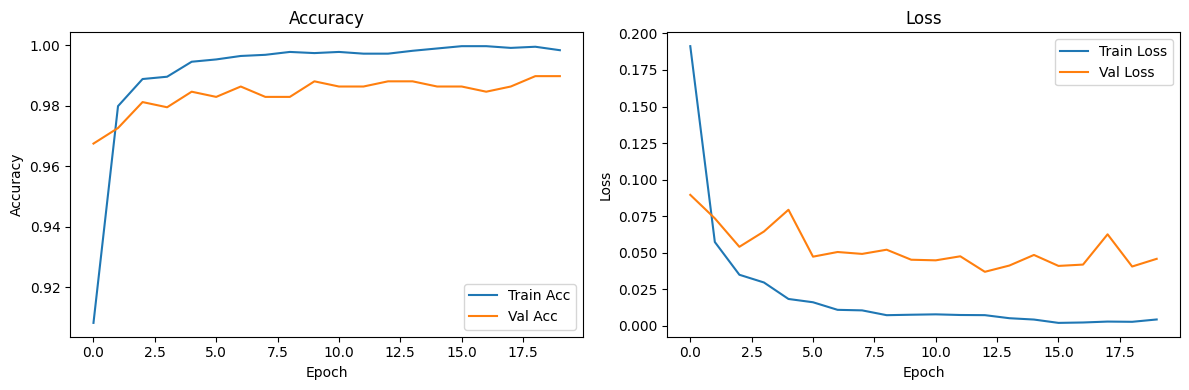

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(X.shape)
print(y.shape)

(1460, 250, 2)
(1460,)


##CNN-LSTM Model Involontary Blink Prediction

In [14]:
# EEG-VV & EEG-VR (Involuntary Blinks)
involuntary_data = pd.concat(
    [
        vv_clean.assign(VoluntaryBlink=0),
        vr_clean.assign(VoluntaryBlink=0)
    ],
    ignore_index=True
)

Data shape: (295100, 250, 2)
Class balance: (array([0, 1]), array([217835,  77265]))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 246, 32)             │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 123, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 123, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 123, 64)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,633 (147.00 KB)

 Trainable params: 37,633 (147.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
6640/6640 ━━━━━━━━━━━━━━━━━━━━ 912s 137ms/step - accuracy: 0.8815 - loss: 0.4347 - precision: 0.7320 - val_accuracy: 0.9542 - val_loss: 0.1253 - val_precision: 0.9006
Epoch 2/12
6640/6640 ━━━━━━━━━━━━━━━━━━━━ 890s 134ms/step - accuracy: 0.9631 - loss: 0.1682 - precision: 0.9088 - val_accuracy: 0.9795 - val_loss: 0.0609 - val_precision: 0.9520
Epoch 3/12
6640/6640 ━━━━━━━━━━━━━━━━━━━━ 912s 133ms/step - accuracy: 0.9780 - loss: 0.1041 - precision: 0.9491 - val_accuracy: 0.9772 - val_loss: 0.0755 - val_precision: 0.9413
Epoch 4/12
6640/6640 ━━━━━━━━━━━━━━━━━━━━ 923s 133ms/step - accuracy: 0.9833 - loss: 0.0819 - precision: 0.9634 - val_accuracy: 0.9883 - val_loss: 0.0378 - val_precision: 0.9779
Epoch 5/12
6640/6640 ━━━━━━━━━━━━━━━━━━━━ 914s 132ms/step - accuracy: 0.9850 - loss: 0.0710 - precision: 0.9675 - val_accuracy: 0.9839 - val_loss: 0.0458 - val_precision: 0.9596
Epoch 6/12
6640/6640 ━━━━━━━━━━━━━━━━━━━━ 943s 135ms/step - accuracy: 0.9865 - loss: 0.0628 - precision: 0.969

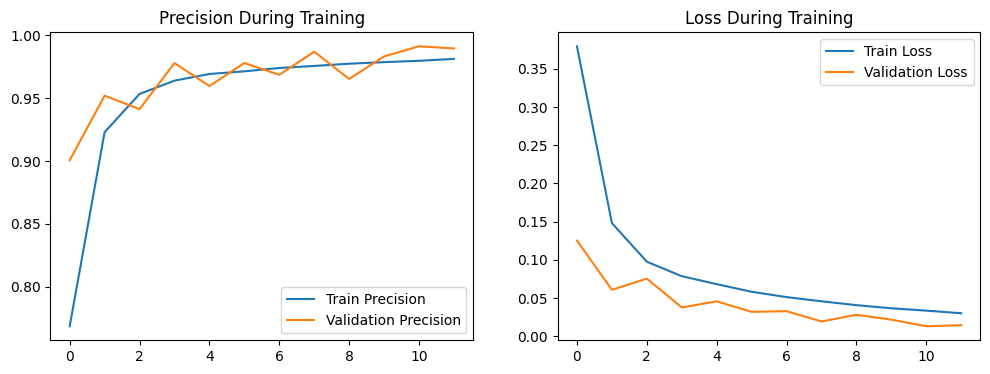


Test Set Performance:
Accuracy: 0.99 | Precision: 0.99

Blink probability in next 200ms: 0.13%


In [15]:
# FP1 and FP2 are our primary channels for blink detection
eeg_data = involuntary_data[['FP1', 'FP2']].values

detected_events = involuntary_data['Blink'].to_numpy().astype(int)


# Create Forecasting Windows
def create_forecast_windows(data, labels, input_steps=250, output_steps=50):
    """Create input/output pairs for blink prediction."""
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        # Check if any blink occurs in next 200ms (50 samples @250Hz)
        y.append(1 if np.any(labels[i+input_steps:i+input_steps+output_steps]) else 0)
    return np.array(X), np.array(y)

X, y = create_forecast_windows(eeg_data, detected_events)

print(f"Data shape: {X.shape}")  # Should be (n_windows, 250, 2)
print(f"Class balance: {np.unique(y, return_counts=True)}")

# 3. Train/Test Split & Normalization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize using training data statistics
train_mean = np.mean(X_train, axis=(0, 1))
train_std = np.std(X_train, axis=(0, 1))

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

#  CNN-LSTM Model
model = Sequential([
    # Feature extraction
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(250, 2)),
    MaxPooling1D(2),
    Dropout(0.3),

    # Temporal modeling
    LSTM(64, return_sequences=True),
    LSTM(32),

    # Prediction
    Dense(1, activation='sigmoid')  # Output blink probability
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])

model.summary()

# 5. Training with Class Weighting
class_counts = np.bincount(y_train)
class_weights = {0: 1.0, 1: class_counts[0]/class_counts[1]}

history = model.fit(
    X_train, y_train,
    epochs=12,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    verbose=1
)

# 6. Evaluation & Visualization
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision During Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

# Test set evaluation
test_loss, test_acc, test_precision = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Set Performance:")
print(f"Accuracy: {test_acc:.2f} | Precision: {test_precision:.2f}")


# 7. Real-Time Prediction Example
def predict_blink_risk(model, recent_eeg):
    """Predict probability of blink in next 200ms."""
    recent_eeg = (recent_eeg - train_mean) / train_std  # Normalize
    return model.predict(recent_eeg[np.newaxis, ...], verbose=0)[0][0]

# Example usage with latest 1s of EEG data
blink_prob = predict_blink_risk(model, X_test[0])
print(f"\nBlink probability in next 200ms: {blink_prob:.2%}")
if blink_prob > 0.8:
    print("ALERT: Delay camera shutter!")

In [21]:
X_full, y_full = create_forecast_windows(eeg_data, detected_events)
pred_probs_full = model.predict(X_full, verbose=0)  # shape: (n_windows, 1)
blink_prob_full = pred_probs_full[:, 0]
predicted_label_full = (blink_prob_full > 0.5).astype(int)


involuntary_data['PredictedBlink'] = 0

window_size = 250
for i in range(len(X_full)):
    start_idx = i
    end_idx = start_idx + window_size - 1
    if end_idx >= len(involuntary_data):
        end_idx = len(involuntary_data) - 1

    involuntary_data.loc[start_idx:end_idx, 'PredictedBlink'] = np.maximum(
        involuntary_data.loc[start_idx:end_idx, 'PredictedBlink'],
        predicted_label_full[i]
    )


In [30]:
involuntary_data.to_csv('involuntary_data1.csv', index=False)

In [28]:
matches = (involuntary_data['Blink'] == involuntary_data['PredictedBlink']).sum()
total_samples = len(involuntary_data)
sample_acc = matches / total_samples
print(f"Sample-level accuracy (with overlap approach): {sample_acc:.2f}")


Sample-level accuracy (with overlap approach): 0.99
